In [71]:
import tensorflow as tf

In [72]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2024-04-02 13:16:17--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.2’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.03s   

2024-04-02 13:16:17 (5.00 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.2’ saved [178509/178509]



In [73]:
import pandas as pd
import numpy as np

In [74]:
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", parse_dates=["Date"], index_col=["Date"])
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [75]:
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)" : "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


<Axes: xlabel='Date'>

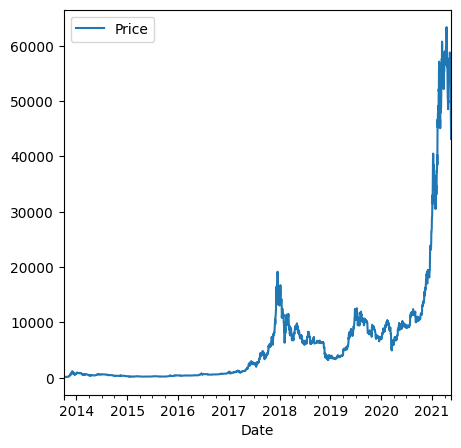

In [76]:
import matplotlib.pyplot as plt
timestamps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices.Price.to_numpy()
bitcoin_prices.plot(figsize=(5,5))

In [77]:
def get_labelled_windows(x, horizon=1):
    return x[:,:-horizon], x[:, -horizon:]


def make_windows(x, window_size=7, horizon=1):
    """
    Turns a 1D array into a 2D array of sequential windows of window_size.
    """
    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
    window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
    windowed_array = x[window_indexes]
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
    return windows, labels

def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)

    return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

def mean_absolute_scaled_error(y_true, y_pred):
    '''
    No seasonality is assumed
    '''
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))
    return mae / mae_naive_no_season

def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("BTC Price")
    if label:
        plt.legend(fontsize=14) # make label bigger
        plt.grid(True)

def make_train_test_splits(windows, labels, test_split=0.2):
    """
    Splits matching pairs of windows and labels into train and test splits.
    """
    split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

def make_preds(model, data):
    return tf.squeeze(model.predict(data))

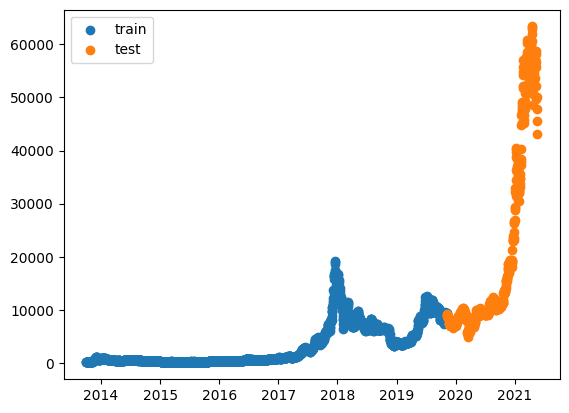

In [78]:
split_size=int(0.8*len(prices))
X_train, y_train = timestamps[:split_size], prices[:split_size]
X_test, y_test = timestamps[split_size:], prices[split_size:]

plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
plt.legend()

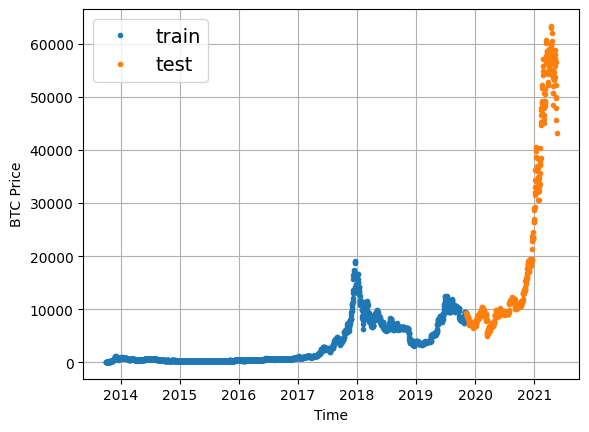

In [79]:
plot_time_series(X_train, y_train, label='train')
plot_time_series(X_test, y_test, label='test')

In [80]:
#naive model

naive_forecast = y_test[:-1]
naive_forecast[:5], y_test[:5]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917]),
 array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917]))

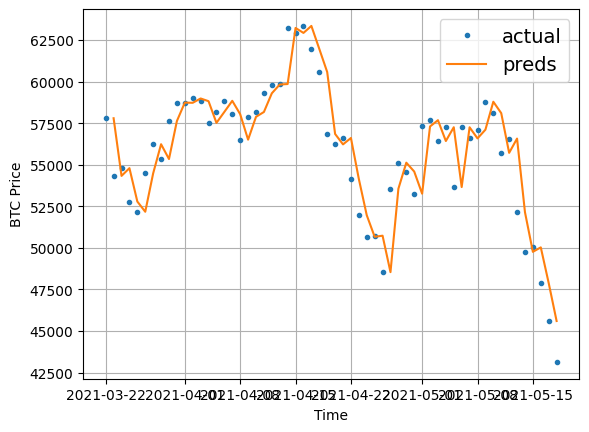

In [81]:
offset = 500
plot_time_series(X_test, y_test, start=offset, label='actual')
plot_time_series(X_test[1:], naive_forecast, start=offset, format='-', label='preds')

In [82]:
model_0_results = evaluate_preds(y_test[1:], naive_forecast)
model_0_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

In [83]:
full_windows, full_labels = make_windows(prices)

In [84]:
for i in range(3):
  print(f"Window : {full_windows[i]} --> {full_labels[i]}")

Window : [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] --> [123.033]
Window : [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] --> [124.049]
Window : [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] --> [125.96116]


In [85]:
len(full_windows)

2780

In [86]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

In [87]:
len(train_windows), len(test_windows)

(2224, 556)

In [88]:
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(1)
])
model_1.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae'])
history_1 = model_1.fit(train_windows, train_labels,
                        epochs=100,
                        validation_data=(test_windows, test_labels),
                        batch_size=128)

Epoch 1/100
18/18 [==============================] - 1s 13ms/step - loss: 1044.2561 - mae: 1044.2561 - val_loss: 1343.2241 - val_mae: 1343.2241
Epoch 2/100
18/18 [==============================] - 0s 4ms/step - loss: 300.7404 - mae: 300.7404 - val_loss: 1384.1790 - val_mae: 1384.1790
Epoch 3/100
18/18 [==============================] - 0s 4ms/step - loss: 247.4834 - mae: 247.4834 - val_loss: 1395.1223 - val_mae: 1395.1223
Epoch 4/100
18/18 [==============================] - 0s 4ms/step - loss: 218.5812 - mae: 218.5812 - val_loss: 1174.8813 - val_mae: 1174.8813
Epoch 5/100
18/18 [==============================] - 0s 4ms/step - loss: 202.5340 - mae: 202.5340 - val_loss: 1080.2375 - val_mae: 1080.2375
Epoch 6/100
18/18 [==============================] - 0s 5ms/step - loss: 188.6297 - mae: 188.6297 - val_loss: 1090.2795 - val_mae: 1090.2795
Epoch 7/100
18/18 [==============================] - 0s 4ms/step - loss: 174.3860 - mae: 174.3860 - val_loss: 1008.5489 - val_mae: 1008.5489
Epoch 8/10

In [89]:
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 582.8763 - mae: 582.8763


[582.8763427734375, 582.8763427734375]

In [90]:
model_1_preds = make_preds(model_1, test_windows)
model_1_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8916.476, 8871.903, 9142.735, 8849.4  , 8814.16 , 8810.512,
       8764.618, 8587.691, 8539.189, 8612.711], dtype=float32)>

In [91]:
model_1_results = evaluate_preds(tf.squeeze(test_labels), model_1_preds)
model_1_results

{'mae': 582.8762,
 'mse': 1197627.1,
 'rmse': 1094.3616,
 'mape': 2.6206727,
 'mase': 1.0239521}

In [92]:
model_0_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

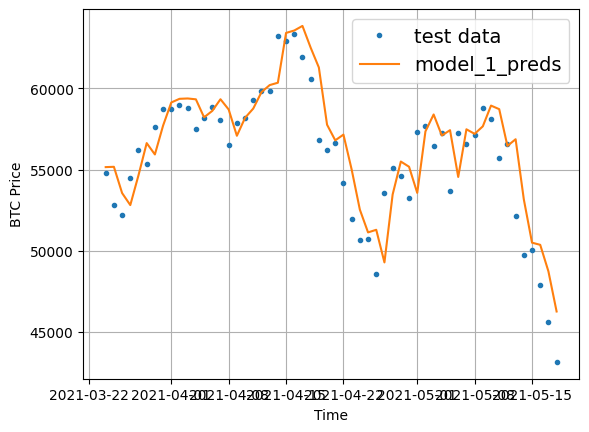

In [93]:
plot_time_series(X_test[-len(test_windows):], test_labels[:, 0], start=500, label='test data')
plot_time_series(X_test[-len(test_windows):], model_1_preds, start=500, format='-', label='model_1_preds')

In [94]:
full_windows_30_1, full_labels_30_1 = make_windows(prices, window_size=30)
train_windows_30_1, test_windows_30_1, train_labels_30_1, test_labels_30_1 = make_train_test_splits(full_windows_30_1,
                                                                                                     full_labels_30_1)
model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(1)
])
model_2.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae'])
history_2 = model_2.fit(train_windows_30_1, train_labels_30_1,
                        epochs=100,
                        validation_data=(test_windows_30_1, test_labels_30_1),
                        batch_size=128)

Epoch 1/100
18/18 [==============================] - 1s 13ms/step - loss: 1535.6843 - mae: 1535.6843 - val_loss: 2732.7546 - val_mae: 2732.7546
Epoch 2/100
18/18 [==============================] - 0s 4ms/step - loss: 542.6684 - mae: 542.6684 - val_loss: 1781.3250 - val_mae: 1781.3250
Epoch 3/100
18/18 [==============================] - 0s 4ms/step - loss: 359.7233 - mae: 359.7233 - val_loss: 1430.4808 - val_mae: 1430.4808
Epoch 4/100
18/18 [==============================] - 0s 4ms/step - loss: 257.2429 - mae: 257.2429 - val_loss: 1537.5940 - val_mae: 1537.5940
Epoch 5/100
18/18 [==============================] - 0s 4ms/step - loss: 243.1834 - mae: 243.1834 - val_loss: 1415.3723 - val_mae: 1415.3723
Epoch 6/100
18/18 [==============================] - 0s 4ms/step - loss: 220.4087 - mae: 220.4087 - val_loss: 1071.8794 - val_mae: 1071.8794
Epoch 7/100
18/18 [==============================] - 0s 5ms/step - loss: 196.6483 - mae: 196.6483 - val_loss: 1038.0802 - val_mae: 1038.0802
Epoch 8/10

In [95]:
model_2_preds = make_preds(model_2, test_windows_30_1)
model_2_results = evaluate_preds(tf.squeeze(test_labels_30_1), model_2_preds)
model_2_results

18/18 [==============================] - 0s 2ms/step


{'mae': 597.91504,
 'mse': 1234910.5,
 'rmse': 1111.2653,
 'mape': 2.7122808,
 'mase': 1.0451612}

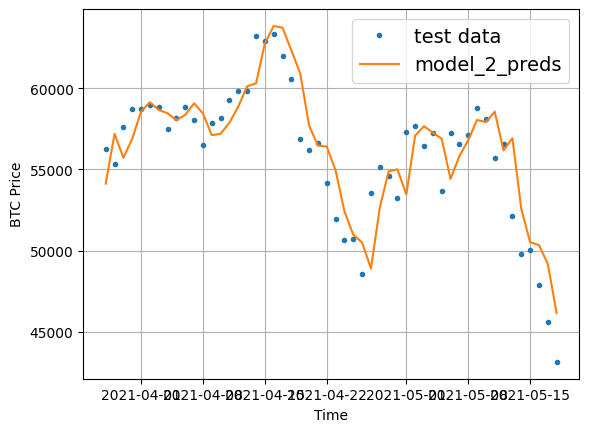

In [96]:
plot_time_series(X_test[-len(test_windows_30_1):], test_labels_30_1[:, 0], start=500, label='test data')
plot_time_series(X_test[-len(test_windows_30_1):], model_2_preds, start=500, format='-', label='model_2_preds')